# Load the Data

In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt


file_name = '/Users/amarmesic/Documents/tudelft/thesis/TestAnalysis/Identifiler/Identifiler_Artifacts/_no_primers_in_negative_E12_BLANK.fsa'

In [2]:
# Load the .fsa file using Biopython
record = SeqIO.read(file_name, "abi")

# Access raw ABI data
channels = record.annotations['abif_raw']

In [3]:
# Store dye channels in a dictionary with color labels
dye_channels = {
    "Blue (DATA9)": channels['DATA9'], # Confirmed to be blue
    "Green (DATA10)": channels['DATA10'], # Confirmed to be green
    "Yellow (DATA11)": channels['DATA11'], # Confirmed to be yellow
    "Red (DATA12)": channels['DATA12'] # Confirmed to be red
}

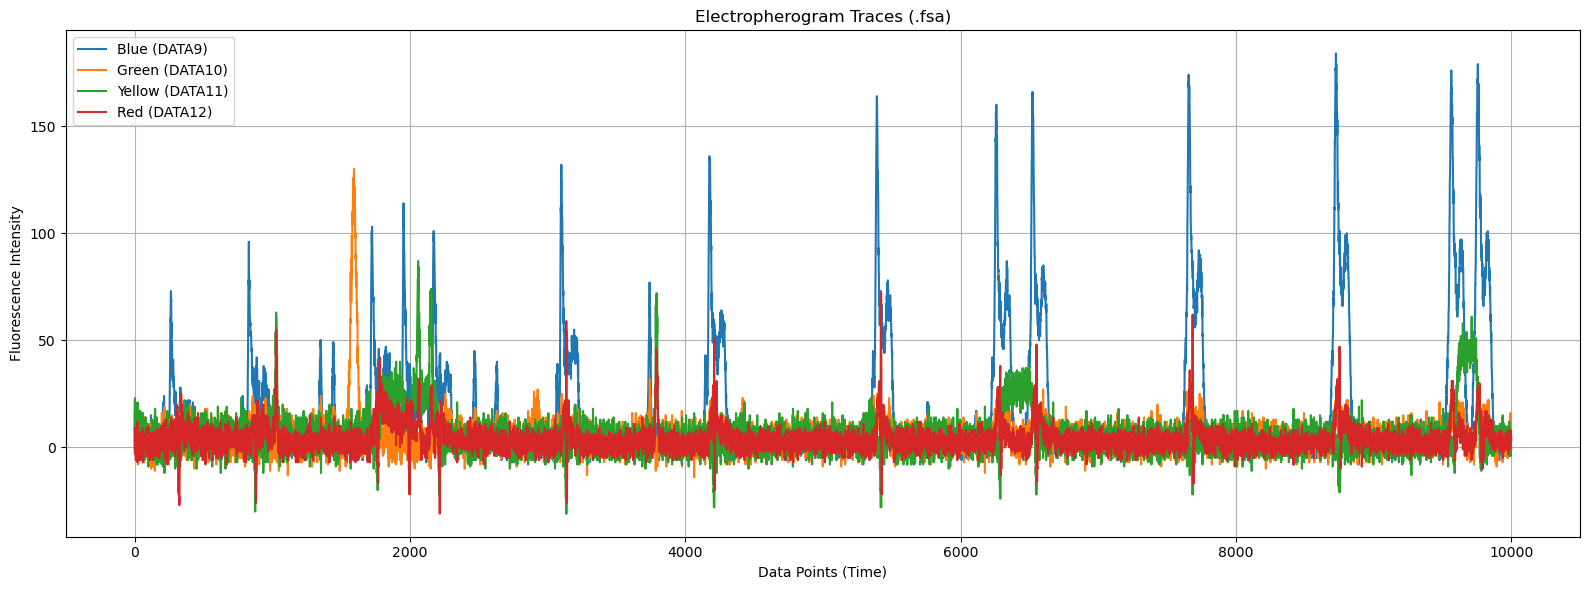

In [4]:
plt.figure(figsize=(16, 6))

for label, signal in dye_channels.items():
    plt.plot(signal[:10000], label=label)

plt.title("Electropherogram Traces (.fsa)")
plt.xlabel("Data Points (Time)")
plt.ylabel("Fluorescence Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Conduct Preprocessing

In [21]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.ndimage import uniform_filter1d

# Stack your signal arrays first
channel_names = ["Blue (DATA9)", "Green (DATA10)", "Yellow (DATA11)", "Red (DATA12)"]
channel_data = np.stack([dye_channels[name][:10000] for name in channel_names])

print("Channel Data:")
print("Shape:", channel_data.shape, 'dtype', channel_data.dtype)  # Check the shape of the stacked data
print(channel_data[:, :5])

# MinMaxScaler expects shape [n_samples, n_features], so transpose
scaler = MinMaxScaler(feature_range=(0, 1))
normalized = scaler.fit_transform(channel_data.T).T  # Transpose twice to keep shape [channels, sequence_length]

# Check shape and sample values
print("\nNormalized Data:")
print("Shape:", normalized.shape, 'dtype:', normalized.dtype)  # Check the shape and data type
print(normalized[:, :5])



Channel Data:
Shape: (4, 10000) dtype int64
[[ 9 17 12 10  8]
 [22  3  5 13 13]
 [-1 16 23  5  6]
 [ 9 -3 -3  4  4]]

Normalized Data:
Shape: (4, 10000) dtype: float64
[[0.08854167 0.13020833 0.10416667 0.09375    0.08333333]
 [0.25       0.11805556 0.13194444 0.1875     0.1875    ]
 [0.25423729 0.39830508 0.45762712 0.30508475 0.31355932]
 [0.38834951 0.27184466 0.27184466 0.33980583 0.33980583]]


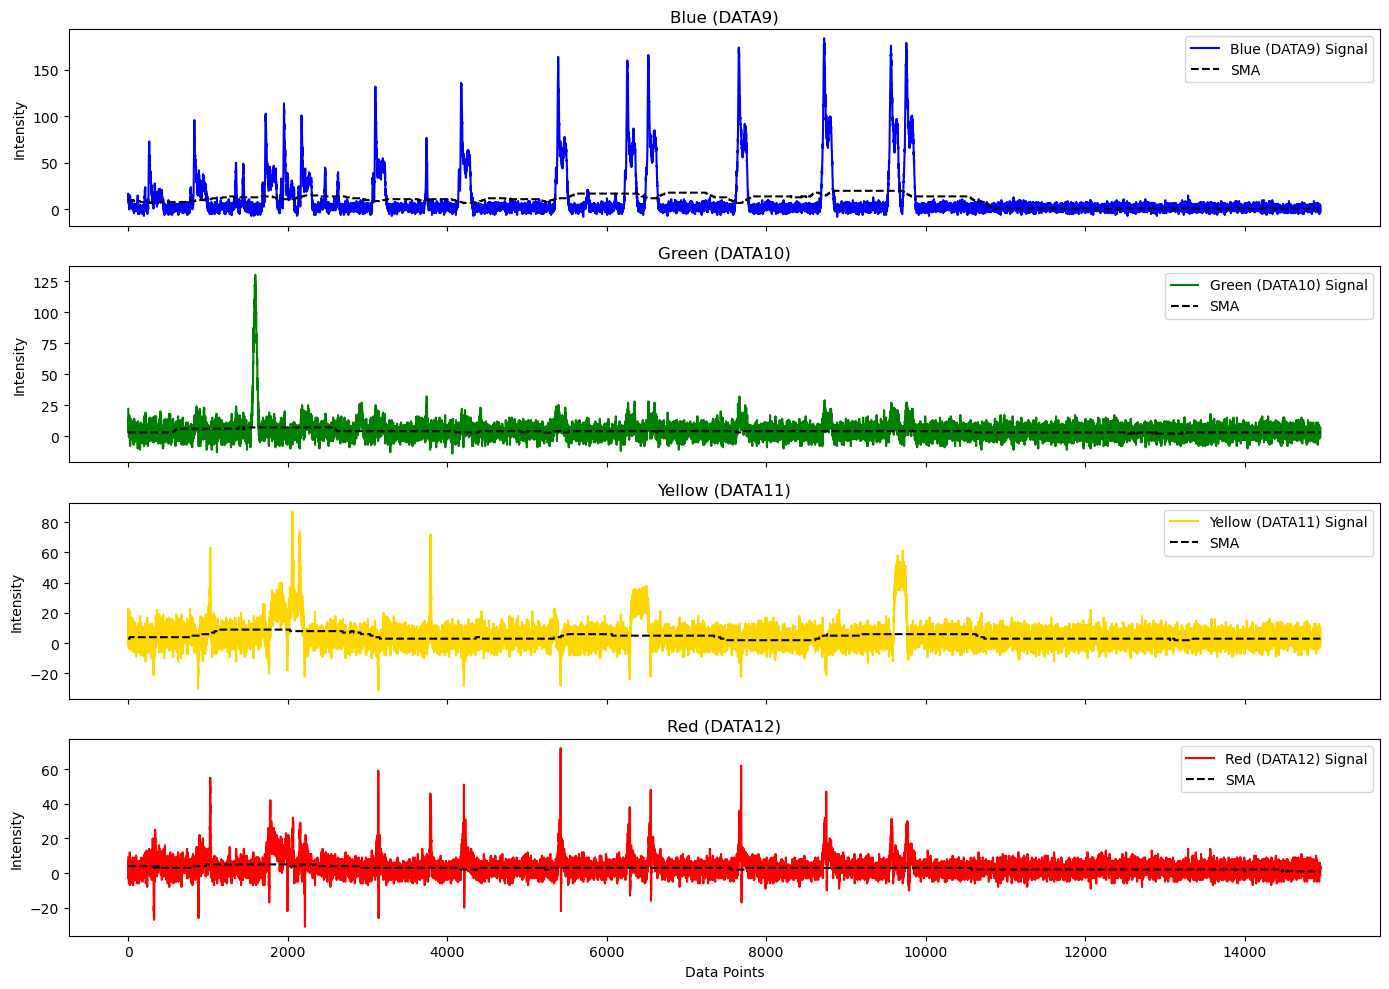

In [28]:
# Parameters
window_size = 2000  # You can adjust this

# Color map for dyes
dye_colors = {
    "Blue (DATA9)": "blue",
    "Green (DATA10)": "green",
    "Yellow (DATA11)": "gold",
    "Red (DATA12)": "red"
}

# Plotting
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
for idx, (dye_name, signal) in enumerate(dye_channels.items()):
    sma = uniform_filter1d(signal, size=window_size)
    ax = axes[idx]
    ax.plot(signal, color=dye_colors[dye_name], label=f"{dye_name} Signal")
    ax.plot(sma, color="black", linestyle="--", label="SMA")
    ax.set_ylabel("Intensity")
    ax.set_title(dye_name)
    ax.legend(loc="upper right")

axes[-1].set_xlabel("Data Points")
plt.tight_layout()
plt.show()

In [29]:
def detrend_sma_nd(signal_array, window_size=2000):
    # Apply SMA and subtract it per channel (axis=1 is time dimension)
    smoothed = uniform_filter1d(signal_array, size=window_size, axis=1)
    detrended = signal_array - smoothed
    return detrended

In [31]:
# signal_array shape: [channels, sequence_length]
detrended_array = detrend_sma_nd(normalized, window_size=2000)

print("Shape:", detrended_array.shape)


Shape: (4, 10000)


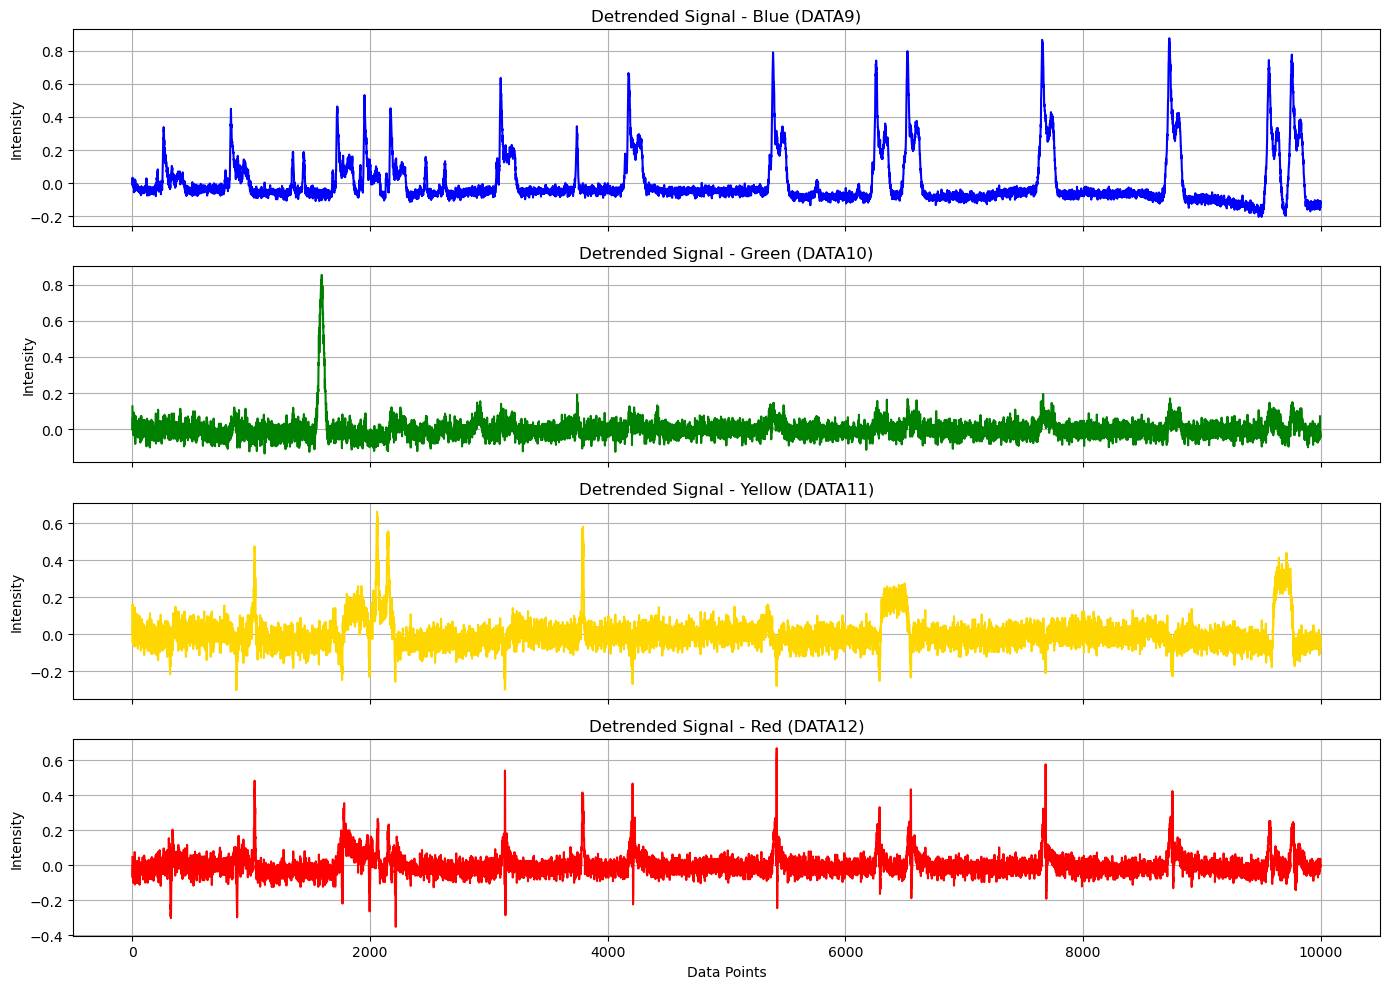

In [32]:
# Plot the detrended signals
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
channel_names = ["Blue (DATA9)", "Green (DATA10)", "Yellow (DATA11)", "Red (DATA12)"]

for i, ax in enumerate(axes):
    ax.plot(detrended_array[i], color=dye_colors[channel_names[i]])
    ax.set_title(f"Detrended Signal - {channel_names[i]}")
    ax.set_ylabel("Intensity")
    ax.grid(True)

axes[-1].set_xlabel("Data Points")
plt.tight_layout()
plt.show()